# Building
  
### Problem explanation

The task is about the prediction of the energy consumption in a building. We try to predict the hourly consumption of electrical energy, hot water, and cold water, based on the date, time of day, outside temperature, outside air humidity, solar radiation, and wind speed.

The data set was created based on problem A of *The Great Energy Predictor Shootout - the first building data analysis and prediction problem* contest, organized in 1993 for the ASHRAE мeeting in Denver, Colorado. The data set itself is located here, in the field building.

This is clearly a regression problem and the results  are three outputs, hourly consumption of electrical energy, hot water, and cold water. The model inputs are:
 
* Day,
* Hour,
* Temperature,
* Humidity,
* Solar radiation,
* Wind speed.

### Problem solution:
The data set contains 4208 observations. We have divided the data set into two sets; the training set, which contains 3366 observations and the test set, which contains 842 observations. We solved problem using following approaches:

* Manually build ANN using Keras,
* Parameter tuning by Grid search,
* Optimize artificial neural network (ANN),
* Optimize random forest (RF).

Note that we didn't make validation set in Black Fox section below, because Black Fox itself makes it from train set we sent to him.

# Data preprocessing

In [1]:
# Importing libraries

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import matplotlib as mpl
mpl.style.use('ggplot')
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import h5py
import time

# Import data

dataframe = pd.read_csv('BuildingData.csv')

#### Dataset info

In [2]:
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4208 entries, 0 to 4207
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Monday     4208 non-null   int64  
 1   Tuesday    4208 non-null   int64  
 2   Wednesday  4208 non-null   int64  
 3   Thursday   4208 non-null   int64  
 4   Friday     4208 non-null   int64  
 5   Saturday   4208 non-null   int64  
 6   Sunday     4208 non-null   int64  
 7   Nhour1     4208 non-null   float64
 8   Nhour2     4208 non-null   float64
 9   Nhour3     4208 non-null   int64  
 10  Temp       4208 non-null   float64
 11  Humid      4208 non-null   float64
 12  Solar      4208 non-null   float64
 13  Wind       4208 non-null   float64
 14  Wbe        4208 non-null   float64
 15  Wbcw       4208 non-null   float64
 16  Wbhw       4208 non-null   float64
dtypes: float64(9), int64(8)
memory usage: 559.0 KB


#### Dataset description

In [3]:
dataframe.describe()

,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday,Nhour1,Nhour2,Nhour3,Temp,Humid,Solar,Wind,Wbe,Wbcw,Wbhw
count,4208.000000,4208.000000,4208.000000,4208.000000,4208.000000,4208.000000,4208.000000,4208.000000,4208.000000,4208.000000,4208.000000,4208.000000,4208.000000,4208.000000,4208.000000,4208.000000,4208.000000
mean,0.144487,0.142586,0.142586,0.142586,0.142586,0.142586,0.142586,0.500079,-0.000992,0.001901,0.609596,0.282694,0.149780,0.236274,0.450551,0.451385,0.339658
std,0.351624,0.349691,0.349691,0.349691,0.349691,0.349691,0.349691,0.290556,0.601920,1.000117,0.162364,0.199956,0.225103,0.125516,0.104934,0.085478,0.144851
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,-1.000000,0.026000,0.000000,0.008774,0.000000,0.259145,0.075000,0.081818
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.250000,-0.565217,-1.000000,0.494000,0.127860,0.010377,0.148214,0.374563,0.397500,0.204545
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,-0.043478,1.000000,0.620000,0.225680,0.012358,0.221965,0.415665,0.450000,0.337500
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.750000,0.478261,1.000000,0.727000,0.413330,0.207146,0.309286,0.522325,0.510000,0.460227
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.995000,0.888000,0.976415,0.938571,0.689082,0.675000,0.726136


#### Histograms of the numerical features

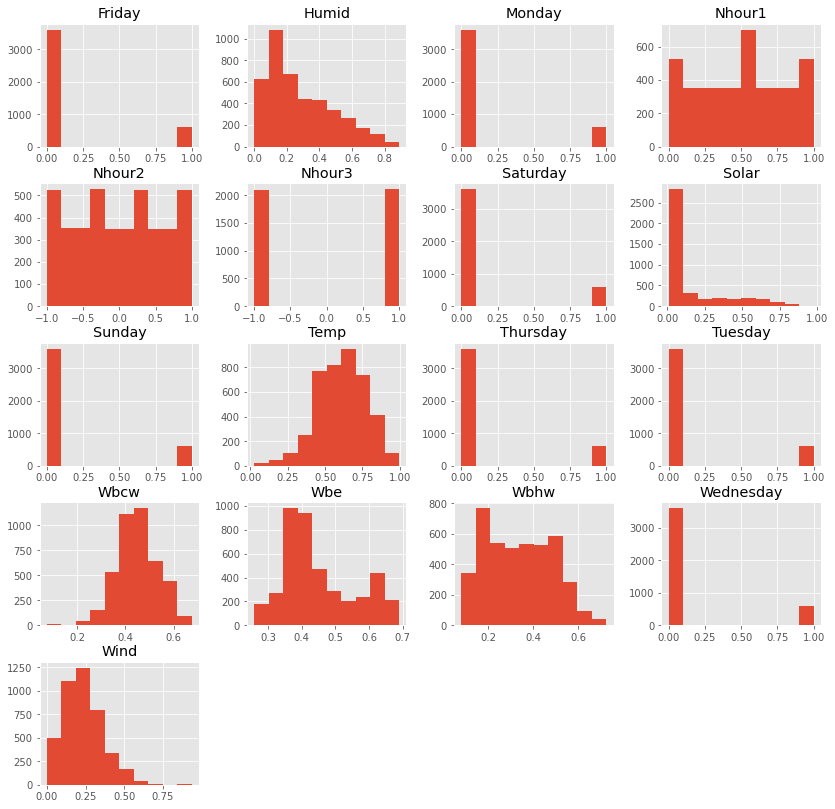

In [4]:
dataframe.hist(figsize=(14,14));

#### Correlation heatmap

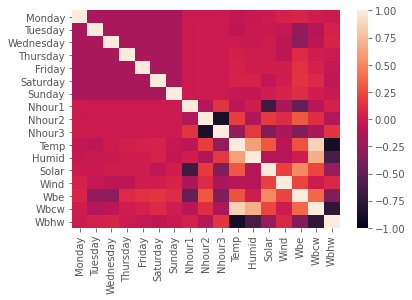

In [5]:
sns.heatmap(dataframe.corr(), vmin=-1, vmax=1);

#### Data preparation

In [6]:
X = dataframe.iloc[:, 1:14].values
y = dataframe.iloc[:, 14:17].values

#### Split the entire data set into the training set and test set

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1)

# Option 1 - manually build ANN using Keras

#### Apply the feature scaling because we don't wanna have any feature dominating another feature

In [8]:
scaler = MinMaxScaler()
X_train_minMaxScaled = scaler.fit_transform(X_train)
X_test_minMaxScaled = scaler.transform(X_test)

In [9]:
# Importing the keras libraries and packages
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import Callback, TensorBoard, ModelCheckpoint
from keras.callbacks import EarlyStopping
import time

start = time.time()

classifier = Sequential()
classifier.add(Dense(units = 9, kernel_initializer = 'uniform', activation = 'sigmoid', input_dim = 13))
classifier.add(Dense(units = 9, kernel_initializer = 'uniform', activation = 'sigmoid'))
classifier.add(Dense(units = 3, kernel_initializer = 'uniform', activation = 'sigmoid'))
es = EarlyStopping(monitor = 'val_loss',
                   mode = 'auto',
                   #min_delta = 0,
                   patience = 30,
                   verbose = 1,
                   #baseline=0.4,
                   restore_best_weights = True
                  )
classifier.compile(optimizer = 'adam', loss = 'mean_absolute_error', metrics = ['accuracy'])
classifier.fit(x = X_train_minMaxScaled, y = y_train, validation_split = 0.3, batch_size = 32, epochs = 500, callbacks = [es], verbose=1)

end = time.time()

time_manually = int(end-start)
minutes, seconds= divmod(time_manually, 60)
hours, minutes= divmod(minutes, 60)

Using TensorFlow backend.


Train on 2356 samples, validate on 1010 samples
Epoch 1/500
2356/2356 [==============================] - 1s 265us/step - loss: 0.1016 - acc: 0.3846 - val_loss: 0.0933 - val_acc: 0.3822
Epoch 2/500
2356/2356 [==============================] - 0s 104us/step - loss: 0.0926 - acc: 0.3846 - val_loss: 0.0915 - val_acc: 0.3822
Epoch 3/500
2356/2356 [==============================] - 0s 112us/step - loss: 0.0920 - acc: 0.3846 - val_loss: 0.0913 - val_acc: 0.3822
.
.
.
Epoch 498/500
2356/2356 [==============================] - 0s 62us/step - loss: 0.0373 - acc: 0.8145 - val_loss: 0.0379 - val_acc: 0.7960
Epoch 499/500
2356/2356 [==============================] - 0s 62us/step - loss: 0.0374 - acc: 0.8154 - val_loss: 0.0377 - val_acc: 0.7921
Epoch 500/500
2356/2356 [==============================] - 0s 68us/step - loss: 0.0374 - acc: 0.8171 - val_loss: 0.0378 - val_acc: 0.7941


#### Compute error

In [10]:
y_pred_manually = classifier.predict(X_test_minMaxScaled)

mse_1 = mean_squared_error(y_test[:,0:1], y_pred_manually[:,0:1])
mse_2 = mean_squared_error(y_test[:,1:2], y_pred_manually[:,1:2])
mse_3 = mean_squared_error(y_test[:,2:3], y_pred_manually[:,2:3])

Rmse1_manual_ANN = np.sqrt(mse_1)
Rmse2_manual_ANN = np.sqrt(mse_2)
Rmse3_manual_ANN = np.sqrt(mse_3)

t_max1 = np.max(y_test[:,0:1])
t_min1 = np.min(y_test[:,0:1])
t_max2 = np.max(y_test[:,1:2])
t_min2 = np.min(y_test[:,1:2])
t_max3 = np.max(y_test[:,2:3])
t_min3 = np.min(y_test[:,2:3])

Prmse1_manual_ANN = 100 * (Rmse1_manual_ANN / (t_max1 - t_min1))
Prmse2_manual_ANN = 100 * (Rmse2_manual_ANN / (t_max2 - t_min2))
Prmse3_manual_ANN = 100 * (Rmse3_manual_ANN / (t_max3 - t_min3))

print("\nTime to manually train one network is ", time_manually,"seconds(",hours,"hours,",minutes,"minutes and ",seconds,"seconds ).")
print("\nRmse(WBE) = ",Rmse1_manual_ANN)
print("Rmse(WBCW) = ",Rmse2_manual_ANN)
print("Rmse(WBHW) = ",Rmse3_manual_ANN)
print("\nPrmse(WBE) = ",Prmse1_manual_ANN,"%")
print("Prmse(WBCW) = ",Prmse2_manual_ANN,"%")
print("Prmse(WBHW) = ",Prmse3_manual_ANN,"%")


Time to manually train one network is  76 seconds( 0 hours, 1 minutes and  16 seconds ).

Rmse(WBE) =  0.05404059685242297
Rmse(WBCW) =  0.038942159539989675
Rmse(WBHW) =  0.061347121854048364

Prmse(WBE) =  13.013677419549916
Prmse(WBCW) =  6.572516378057329
Prmse(WBHW) =  10.166747764834389


#### Visualization of the results

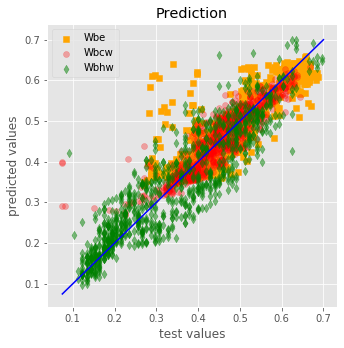

In [11]:
plt.figure(1, figsize=(5.2,5.2))
plt.scatter(y_test[:,0],y_pred_manually[:,0], color = 'orange', marker = 's', alpha = 1, label = 'Wbe')
plt.scatter(y_test[:,1],y_pred_manually[:,1], color = 'red', marker = 'o', alpha = 0.3, label = 'Wbcw')
plt.scatter(y_test[:,2],y_pred_manually[:,2], color = 'green', marker = 'd', alpha = 0.5, label = 'Wbhw')
plt.title('Prediction')
plt.xlabel('test values')
plt.ylabel('predicted values')
_=plt.plot([min(np.min(y_test),np.min(y_pred_manually)), max(np.max(y_test),np.max(y_pred_manually))],[min(np.min(y_test),np.min(y_pred_manually)), max(np.max(y_test),np.max(y_pred_manually))], color = 'blue', alpha = 1)
plt.legend(loc = 'upper left');

# Option 2 - Parameter tuning by Grid search
We have two type of model parameters, __the weights__ obtained during training process, and parameters that stay fixed, called the __hyperparameters__. The examples of the hyperparameters are __number of epochs__, __batch size__, __type of optimizer__, __number of layers__, __the number of neurons per layer__ etc. The ANN trained in __Option 1__ used fixed values of these hyperparameters, but **perhaps some other values would lead us to a better accuracy**!

The parameter tuning is all about finding the best values of the hyperparameters. We will try this using a simple technique called __Grid search__ that will test several hyperparameter combinations and return the best choice that leads to the best accuracy.

In [12]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Dense
import time

start = time.time()

def build_classifier(optimizer):
   classifier = Sequential()
   classifier.add(Dense(units = 9, kernel_initializer = 'uniform', activation = 'sigmoid', input_dim = 13))
   classifier.add(Dense(units = 9, kernel_initializer = 'uniform', activation = 'sigmoid'))
   classifier.add(Dense(units = 3, kernel_initializer = 'uniform', activation = 'sigmoid'))
   classifier.compile(optimizer = optimizer, loss = 'mean_absolute_error', metrics = ['accuracy'])
   return classifier

Tuning_classifier = KerasClassifier(build_fn = build_classifier)
parameters = {'batch_size': [25, 32],
              'epochs': [100, 500],
              'optimizer': ['adam', 'rmsprop']
             }

grid_search = GridSearchCV(estimator = Tuning_classifier,
                           param_grid = parameters,
                           #scoring = 'accuracy',
                           cv = 10,
                          )

grid_search = grid_search.fit(X_train_minMaxScaled, y_train)

best_parameters = grid_search.best_params_
best_accuracy = grid_search.best_score_

print("\nBest parameters are :\n", best_parameters)
print("\nBest accuracy is :\n", best_accuracy)


end = time.time()

time_tuned = int(end - start)
minutes, seconds= divmod(time_tuned, 60)
hours, minutes= divmod(minutes, 60)

Epoch 1/100
3029/3029 [==============================] - 0s 137us/step - loss: 0.0982 - acc: 0.3688
Epoch 2/100
3029/3029 [==============================] - 0s 59us/step - loss: 0.0919 - acc: 0.3840
Epoch 3/100
3029/3029 [==============================] - 0s 55us/step - loss: 0.0917 - acc: 0.3840
.
.
.
Epoch 498/500
3366/3366 [==============================] - 0s 114us/step - loss: 0.0372 - acc: 0.8149
Epoch 499/500
3366/3366 [==============================] - 0s 96us/step - loss: 0.0372 - acc: 0.8143
Epoch 500/500
3366/3366 [==============================] - 0s 98us/step - loss: 0.0372 - acc: 0.8167

Best parameters are :
 {'batch_size': 32, 'epochs': 500, 'optimizer': 'adam'}

Best accuracy is :
 0.32055852653163214


#### Compute error

In [13]:
y_pred_tuned = classifier.predict(X_test_minMaxScaled)

mse_1 = mean_squared_error(y_test[:,0:1], y_pred_tuned[:,0:1])
mse_2 = mean_squared_error(y_test[:,1:2], y_pred_tuned[:,1:2])
mse_3 = mean_squared_error(y_test[:,2:3], y_pred_tuned[:,2:3])

Rmse1_tuned_ANN = np.sqrt(mse_1)
Rmse2_tuned_ANN = np.sqrt(mse_2)
Rmse3_tuned_ANN = np.sqrt(mse_3)

t_max1 = np.max(y_test[:,0:1])
t_min1 = np.min(y_test[:,0:1])
t_max2 = np.max(y_test[:,1:2])
t_min2 = np.min(y_test[:,1:2])
t_max3 = np.max(y_test[:,2:3])
t_min3 = np.min(y_test[:,2:3])

Prmse1_tuned_ANN = 100 * (Rmse1_tuned_ANN / (t_max1 - t_min1))
Prmse2_tuned_ANN = 100 * (Rmse2_tuned_ANN / (t_max2 - t_min2))
Prmse3_tuned_ANN = 100 * (Rmse3_tuned_ANN / (t_max3 - t_min3))

print("\nTime to manually train one network is ", time_tuned,"seconds(",hours,"hours,",minutes,"minutes and ",seconds,"seconds ).")
print("\nRmse(WBE) = ",Rmse1_tuned_ANN)
print("Rmse(WBCW) = ",Rmse2_tuned_ANN)
print("Rmse(WBHW) = ",Rmse3_tuned_ANN)
print("\nPrmse(WBE) = ",Prmse1_tuned_ANN,"%")
print("Prmse(WBCW) = ",Prmse2_tuned_ANN,"%")
print("Prmse(WBHW) = ",Prmse3_tuned_ANN,"%")


Time needed for tuning is  7144 seconds( 1 hours, 59 minutes and  4 seconds).

Rmse(WBE) =  0.05420678561614596
Rmse(WBCW) =  0.0402420110770949
Rmse(WBHW) =  0.06042263827405371

Prmse(WBE) =  13.053697831755038
Prmse(WBCW) =  6.791900603729097
Prmse(WBHW) =  10.013537783885356


#### Visualization of the results

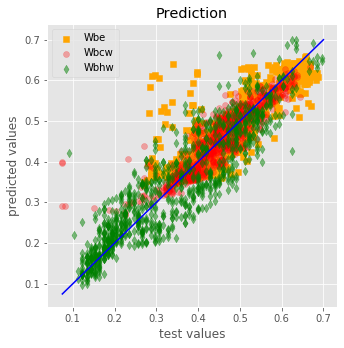

In [14]:
plt.figure(1, figsize=(5.2,5.2))
plt.scatter(y_test[:,0],y_pred_tuned[:,0], color = 'orange', marker = 's', alpha = 1, label = 'Wbe')
plt.scatter(y_test[:,1],y_pred_tuned[:,1], color = 'red', marker = 'o', alpha = 0.3, label = 'Wbcw')
plt.scatter(y_test[:,2],y_pred_tuned[:,2], color = 'green', marker = 'd', alpha = 0.5, label = 'Wbhw')
plt.title('Prediction')
plt.xlabel('test values')
plt.ylabel('predicted values')
_=plt.plot([min(np.min(y_test),np.min(y_pred_tuned)), max(np.max(y_test),np.max(y_pred_tuned))],[min(np.min(y_test),np.min(y_pred_tuned)), max(np.max(y_test),np.max(y_pred_tuned))], color = 'blue', alpha = 1)
plt.legend(loc = 'upper left');

# Option 3 - Optimize Artificial Neural Network (ANN) automatically using Black Fox service

#### Install Black fox service

In [15]:
!pip install blackfox

     |████████████████████████████████| 81kB 243kB/s eta 0:00:01
You should consider upgrading via the 'pip install --upgrade pip' command.


#### Black Fox scales data automatically so we will not scale it manually. In order to apply obtained models in prediction, Black Fox offers the utility function to scale our test set the same way used to scale the trainig set, let's install Black Fox extras.

In [16]:
!pip install blackfox_extras

     |████████████████████████████████| 7.0MB 32kB/s  eta 0:00:01     |██████████                      | 2.2MB 2.6MB/s eta 0:00:02
     |████████████████████████████████| 296kB 8.3MB/s eta 0:00:01
  Found existing installation: scikit-learn 0.19.1
    Uninstalling scikit-learn-0.19.1:
      Successfully uninstalled scikit-learn-0.19.1


In [17]:
# Importing Black Fox service libraries

from blackfox import BlackFox
from blackfox import AnnOptimizationConfig, RandomForestOptimizationConfig, XGBoostOptimizationConfig
from blackfox import AnnOptimizationEngineConfig, OptimizationEngineConfig
from blackfox import LogWriter, CsvLogWriter
from blackfox_extras import prepare_input_data, scale_output_data, prepare_output_data
from tensorflow.keras.models import load_model
import joblib
import xgboost as xgb

blackfox_url = 'localhost:32723'
bf = BlackFox(blackfox_url)

#### Let's run the Black Fox service to find best ANN for the specific problem. Note that we optimize the architecture, as well!

In [18]:
c = AnnOptimizationConfig(
    problem_type = "Regression"
    )

start = time.time()

# Use CTRL + C to stop optimization
(ann_io, ann_info, ann_metadata) = bf.optimize_ann(
    input_set = X_train,
    output_set = y_train,
    config = c,
    model_path = 'model_building.h5'
)

end = time.time()
time_BF_ANN = int(end-start)

print('\nann info:')
print(ann_info)

print('\nann metadata:')
print(ann_metadata)

Uploading training data
Starting...
Use CTRL + C to stop optimization
Evaluating initial models
Evaluating initial models
Evaluating initial models
2020-10-14 22:43:07.599712 - Active, Generation: 0/50, Validation set MAE: 0.063904, Training set MAE: 0.062934, Epoch: 2999, Optimization Id: 0b4c1a65-346c-4416-9f0b-c2c0eda54982
2020-10-14 22:43:12.791341 - Active, Generation: 0/50, Validation set MAE: 0.063904, Training set MAE: 0.062934, Epoch: 2999, Optimization Id: 0b4c1a65-346c-4416-9f0b-c2c0eda54982
2020-10-14 22:43:17.981364 - Active, Generation: 0/50, Validation set MAE: 0.063904, Training set MAE: 0.062934, Epoch: 2999, Optimization Id: 0b4c1a65-346c-4416-9f0b-c2c0eda54982
.
.
.
2020-10-15 00:30:55.811330 - Active, Generation: 32/50, Validation set MAE: 0.058313, Training set MAE: 0.055857, Epoch: 2966, Optimization Id: 0b4c1a65-346c-4416-9f0b-c2c0eda54982
2020-10-15 00:31:01.342218 - Active, Generation: 32/50, Validation set MAE: 0.058313, Training set MAE: 0.055857, Epoch: 2966

#### Prediction using ANN proposed by Black Fox

In [19]:
model_name = 'model_building.h5'

# Load model
BF_ann_model = load_model(model_name)

# Get metadata
ann_metadata = bf.get_ann_metadata(model_name)

# Scale test input data, as Black Fox did in the optimization, in order to make prediction
X_test_scaled = prepare_input_data(X_test, ann_metadata)

# Prediction
y_pred = BF_ann_model.predict(X_test_scaled)

# Rescale predicted data to real values
y_pred_BF_ann = scale_output_data(y_pred, ann_metadata)

#### Compute error

In [20]:
mse_1 = mean_squared_error(y_test[:,0:1], y_pred_BF_ann[:,0:1])
mse_2 = mean_squared_error(y_test[:,1:2], y_pred_BF_ann[:,1:2])
mse_3 = mean_squared_error(y_test[:,2:3], y_pred_BF_ann[:,2:3])

Rmse1_BF_ANN = np.sqrt(mse_1)
Rmse2_BF_ANN = np.sqrt(mse_2)
Rmse3_BF_ANN = np.sqrt(mse_3)

t_max1 = np.max(y_test[:,0:1])
t_min1 = np.min(y_test[:,0:1])
t_max2 = np.max(y_test[:,1:2])
t_min2 = np.min(y_test[:,1:2])
t_max3 = np.max(y_test[:,2:3])
t_min3 = np.min(y_test[:,2:3])

Prmse1_BF_ANN = 100 * (Rmse1_BF_ANN / (t_max1 - t_min1))
Prmse2_BF_ANN = 100 * (Rmse2_BF_ANN / (t_max2 - t_min2))
Prmse3_BF_ANN = 100 * (Rmse3_BF_ANN / (t_max3 - t_min3))

minutes, seconds = divmod(time_BF_ANN, 60)
hours, minutes = divmod(minutes, 60)

print("\nTime for finding the best ANN by Black Fox service is", time_BF_ANN,"seconds(",hours,"hours,",minutes,"minutes and ",seconds,"seconds).")
print("\nRmse(WBE) = ",Rmse1_BF_ANN)
print("Rmse(WBCW) = ",Rmse2_BF_ANN)
print("Rmse(WBHW) = ",Rmse3_BF_ANN)
print("\nPrmse(WBE) = ",Prmse1_BF_ANN,"%")
print("Prmse(WBCW) = ",Prmse2_BF_ANN,"%")
print("Prmse(WBHW) = ",Prmse3_BF_ANN,"%")


Time to manually train one network is  4020 seconds( 1 hours, 7 minutes and  0 seconds ).

Rmse(WBE) =  0.049800782915087306
Rmse(WBCW) =  0.03482848631118971
Rmse(WBHW) =  0.05487128273750062

Prmse(WBE) =  11.992675170998245 %
Prmse(WBCW) =  5.878225537753537 %
Prmse(WBHW) =  9.09353974995432 %


#### Visualization of the results

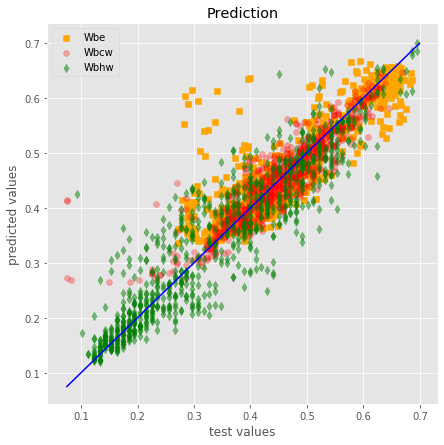

In [21]:
plt.figure(1, figsize=(7,7))
plt.scatter(y_test[:,0],y_pred_BF_ann[:,0], color = 'orange', marker = 's', alpha = 1, label = 'Wbe')
plt.scatter(y_test[:,1],y_pred_BF_ann[:,1], color = 'red', marker = 'o', alpha = 0.3, label = 'Wbcw')
plt.scatter(y_test[:,2],y_pred_BF_ann[:,2], color = 'green', marker = 'd', alpha = 0.5, label = 'Wbhw')
plt.title('Prediction')
plt.xlabel('test values')
plt.ylabel('predicted values')
_=plt.plot([min(np.min(y_test),np.min(y_pred_BF_ann)), max(np.max(y_test),np.max(y_pred_BF_ann))],[min(np.min(y_test),np.min(y_pred_BF_ann)), max(np.max(y_test),np.max(y_pred_BF_ann))], color = 'blue', alpha = 1)
plt.legend(loc = 'upper left');

# Option 4 - Optimize Random Forest (RF) automatically using Black Fox service

#### Let's run the Black Fox service to find best RF for the specific problem. Note that we optimize the architecture, as well!

In [22]:
start = time.time()

c = RandomForestOptimizationConfig(
    problem_type = 'Regression'
)

# Use CTRL + C to stop optimization
(rf_io, rf_info, rf_metadata) = bf.optimize_random_forest(
    input_set = X_train,
    output_set = y_train,
    config = c,
    model_path = 'model_building.rf'
)

end = time.time()
time_BF_RF = int(end-start)

print('\nrf info:')
print(rf_info)

print('\nrf metadata:')
print(rf_metadata)

Uploading training data
Starting...
Use CTRL + C to stop optimization
Evaluating initial models
Evaluating initial models
Evaluating initial models
2020-10-20 08:44:37.988916 - Active, Generation: 0/50, Validation set MAE: 0.053455, Training set MAE: 0.021746, Optimization Id: 39c45acc-a7cd-4bf0-b4c7-7b15c0ba80c0
2020-10-20 08:44:45.344397 - Active, Generation: 0/50, Validation set MAE: 0.053455, Training set MAE: 0.021746, Optimization Id: 39c45acc-a7cd-4bf0-b4c7-7b15c0ba80c0
2020-10-20 08:44:52.354246 - Active, Generation: 0/50, Validation set MAE: 0.053455, Training set MAE: 0.021746, Optimization Id: 39c45acc-a7cd-4bf0-b4c7-7b15c0ba80c0
.
.
.
2020-10-20 09:13:42.227555 - Active, Generation: 26/50, Validation set MAE: 0.052974, Training set MAE: 0.021766, Optimization Id: 39c45acc-a7cd-4bf0-b4c7-7b15c0ba80c0
2020-10-20 09:20:10.157349 - Active, Generation: 26/50, Validation set MAE: 0.052974, Training set MAE: 0.021766, Optimization Id: 39c45acc-a7cd-4bf0-b4c7-7b15c0ba80c0
2020-10-2

#### Prediction using RF proposed by Black Fox

In [23]:
model_name = 'model_building.rf'

# Load model
BF_rf_model = joblib.load(model_name)

# Get metadata
rf_metadata = bf.get_random_forest_metadata(model_name)

# Scale test input data, as Black Fox did in the optimization, in order to make prediction
X_test_scaled = prepare_input_data(X_test, rf_metadata)

# Prediction
y_pred = BF_rf_model.predict(X_test_scaled).reshape(y_test.shape[0], y_test.shape[1])

# Rescale predicted data to real values
y_pred_BF_rf = scale_output_data(y_pred, rf_metadata)

#### Compute error

In [24]:
mse_1 = mean_squared_error(y_test[:,0:1], y_pred_BF_rf[:,0:1])
mse_2 = mean_squared_error(y_test[:,1:2], y_pred_BF_rf[:,1:2])
mse_3 = mean_squared_error(y_test[:,2:3], y_pred_BF_rf[:,2:3])

Rmse1_BF_RF = np.sqrt(mse_1)
Rmse2_BF_RF = np.sqrt(mse_2)
Rmse3_BF_RF = np.sqrt(mse_3)

t_max1 = np.max(y_test[:,0:1])
t_min1 = np.min(y_test[:,0:1])
t_max2 = np.max(y_test[:,1:2])
t_min2 = np.min(y_test[:,1:2])
t_max3 = np.max(y_test[:,2:3])
t_min3 = np.min(y_test[:,2:3])

Prmse1_BF_RF = 100 * (Rmse1_BF_RF / (t_max1 - t_min1))
Prmse2_BF_RF = 100 * (Rmse2_BF_RF / (t_max2 - t_min2))
Prmse3_BF_RF = 100 * (Rmse3_BF_RF / (t_max3 - t_min3))

minutes, seconds = divmod(time_BF_RF, 60)
hours, minutes = divmod(minutes, 60)

print("\nTime for finding the best RF by Black Fox service is", time_BF_RF,"seconds(",hours,"hours,",minutes,"minutes and ",seconds,"seconds).")
print("\nRmse(WBE) = ",Rmse1_BF_RF)
print("Rmse(WBCW) = ",Rmse2_BF_RF)
print("Rmse(WBHW) = ",Rmse3_BF_RF)
print("\nPrmse(WBE) = ",Prmse1_BF_RF,"%")
print("Prmse(WBCW) = ",Prmse2_BF_RF,"%")
print("Prmse(WBHW) = ",Prmse3_BF_RF,"%")


Time for finding the best RF by Black Fox service is 2593 seconds( 0 hours, 43 minutes and  13 seconds).

Rmse(WBE) =  0.045763322136934986
Rmse(WBCW) =  0.03203962511369099
Rmse(WBHW) =  0.04690378819487288

Prmse(WBE) =  11.020402190660066 %
Prmse(WBCW) =  5.407531664757973 %
Prmse(WBHW) =  7.773127236954816 %


#### Visualization of the results

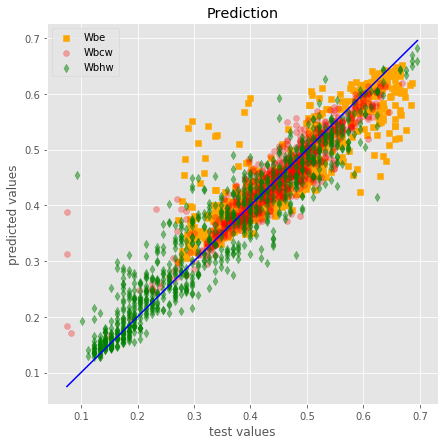

In [25]:
plt.figure(1, figsize=(7,7))
plt.scatter(y_test[:,0],y_pred_BF_rf[:,0], color = 'orange', marker = 's', alpha = 1, label = 'Wbe')
plt.scatter(y_test[:,1],y_pred_BF_rf[:,1], color = 'red', marker = 'o', alpha = 0.3, label = 'Wbcw')
plt.scatter(y_test[:,2],y_pred_BF_rf[:,2], color = 'green', marker = 'd', alpha = 0.5, label = 'Wbhw')
plt.title('Prediction')
plt.xlabel('test values')
plt.ylabel('predicted values')
_=plt.plot([min(np.min(y_test),np.min(y_pred_BF_rf)), max(np.max(y_test),np.max(y_pred_BF_rf))],[min(np.min(y_test),np.min(y_pred_BF_rf)), max(np.max(y_test),np.max(y_pred_BF_rf))], color = 'blue', alpha = 1)
plt.legend(loc = 'upper left');

# Results and Discussion

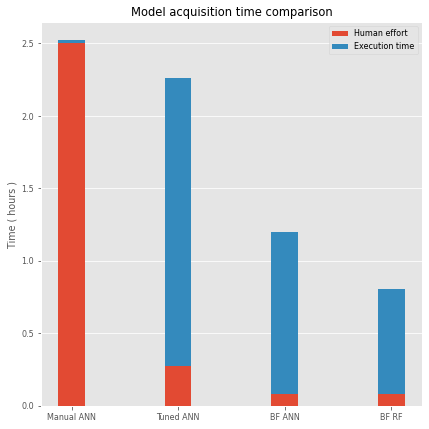

In [26]:
plt.style.use('ggplot')
mpl.rc('lines', linewidth=1)
mpl.rc('font', size='8')

Human_time_manual = 9000
Human_time_tuned = 1000
Human_time_BF_ANN = 300
Human_time_BF_RF = 300

n_groups = 4
group_1 = (Human_time_manual/3600, Human_time_tuned/3600, Human_time_BF_ANN/3600, Human_time_BF_RF/3600)
group_2 = (time_manual/3600, time_tuned/3600, time_BF_ANN/3600, time_BF_RF/3600)

# Create plot
fig, ax = plt.subplots(figsize=(6,6))
ax.xaxis.grid(False)
index = np.arange(n_groups)
bar_width = 0.25
space = 0.05
opacity = 1
  
rects1 = plt.bar(index, group_1, bar_width,align ='center',
alpha=opacity,
label='Human effort')

rects2 = plt.bar(index, group_2, bar_width,align ='center',bottom =group_1,
alpha=opacity,
label='Execution time')

plt.title('Model acquisition time comparison')
plt.xticks(index, ('Manual ANN', 'Tuned ANN', 'BF ANN', 'BF RF'))
plt.legend(loc = 'best')
 
plt.ylabel('Time ( hours )')
plt.tight_layout()
plt.show()

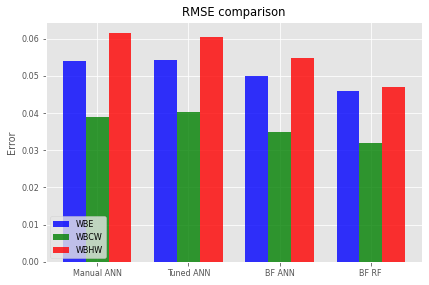

In [27]:
n_groups = 4
group_1 = (Rmse1_manual_ANN, Rmse1_tuned_ANN, Rmse1_BF_ANN, Rmse1_BF_RF)
group_2 = (Rmse2_manual_ANN, Rmse2_tuned_ANN, Rmse2_BF_ANN, Rmse2_BF_RF)
group_3 = (Rmse3_manual_ANN, Rmse3_tuned_ANN, Rmse3_BF_ANN, Rmse3_BF_RF)
 
# create plot
fig, ax = plt.subplots()
index = np.arange(n_groups)

bar_width = 0.25
opacity = 0.8
 
rects1 = plt.bar(index, group_1, bar_width,
alpha=opacity,
color='b',
label='WBE')
 
rects2 = plt.bar(index + bar_width, group_2, bar_width,
alpha=opacity,
color='g',
label='WBCW')

rects3 = plt.bar(index + bar_width + bar_width, group_3, bar_width,
alpha=opacity,
color='r',
label='WBHW')
 
#plt.xlabel('Person')
plt.ylabel('Error')

plt.title('RMSE comparison')
plt.xticks(index + bar_width, ('Manual ANN', 'Tuned ANN', 'BF ANN', 'BF RF'))
plt.legend(loc = 'lower left')
 
plt.tight_layout()
plt.show()

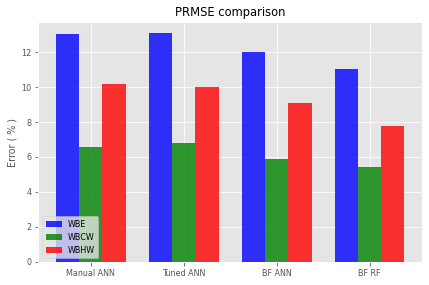

In [28]:
n_groups = 4
group_1 = (Prmse1_manual_ANN, Prmse1_tuned_ANN, Prmse1_BF_ANN, Prmse1_BF_RF)
group_2 = (Prmse2_manual_ANN, Prmse2_tuned_ANN, Prmse2_BF_ANN, Prmse2_BF_RF)
group_3 = (Prmse3_manual_ANN, Prmse3_tuned_ANN, Prmse3_BF_ANN, Prmse3_BF_RF)
 
# create plot
fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.25
opacity = 0.8
 
rects1 = plt.bar(index, group_1, bar_width,
alpha=opacity,
color='b',
label='WBE')
 
rects2 = plt.bar(index + bar_width, group_2, bar_width,
alpha=opacity,
color='g',
label='WBCW')

rects3 = plt.bar(index + bar_width + bar_width, group_3, bar_width,
alpha=opacity,
color='r',
label='WBHW')
 
#plt.xlabel('Person')
plt.ylabel('Error ( % )')

plt.title('PRMSE comparison')
plt.xticks(index + bar_width, ('Manual ANN', 'Tuned ANN', 'BF ANN', 'BF RF'))
plt.legend(loc = 'lower left')
 
plt.tight_layout()
plt.show()

# Conclusion
Although we benchmarked all these options, actually they are not completely comparable, because in **Option 1** and **Option 2** a neural network expert is required,  while when using the Black Fox service (other options), we imported the same data set and the service carried out the rest. In fact, only few lines of code are required to invoke the Black Fox service and that's all. Results in the given plots above speak for themselves. The Black Fox service gave better results with less time and effort invested.